In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from pandas import ExcelWriter
#clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)
%matplotlib inline

In [3]:
scaler = StandardScaler()

In [4]:
location='Задача.xlsx'
df=pd.read_excel(location)

In [7]:
df.columns

Index(['Персона', 'Возраст, лет', 'Стаж вождения, лет', 'Убыточность, %',
       'Уровень заработной платы, руб/год'],
      dtype='object')

In [9]:
df=df.drop('Персона', axis=1)

Смотрим на наличие пропусков

In [5]:
df.isnull().values.any()

False

In [10]:
X=scaler.fit_transform(df)
X=pd.DataFrame(X)
X.columns=df.columns

Создаем линкейдж и дендрограмму

In [11]:
Z = linkage(X, method = 'ward')

In [12]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

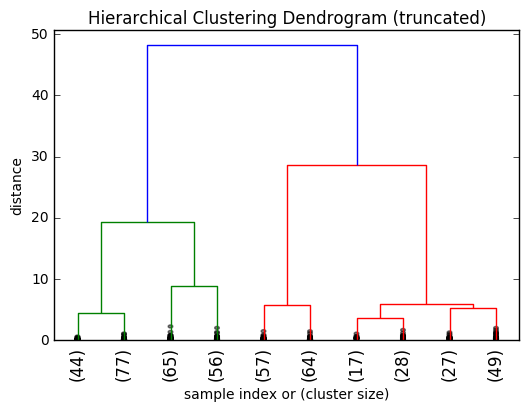

In [14]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=10,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [15]:
h_labels=fcluster(Z, 10 , criterion='distance')

In [16]:
def cluster_labels(X, threshold):
    Z = linkage(X, method='ward')
    h_labels=fcluster(Z, threshold , criterion='distance')
    final=df.copy()
    final['final_labels']=h_labels
    unique_labels=final['final_labels'].value_counts().index.tolist()
    final.final_labels.replace(unique_labels,[i+1 for i in range(len(unique_labels))],inplace=True)
    return final

In [17]:
final=cluster_labels(X, 10)

In [18]:
final=df.copy()
final['final_labels']=h_labels

# Смотрим на получившиеся сегменты и описываем их

In [19]:
final['final_labels'].value_counts()

4    121
3    121
2    121
1    121
Name: final_labels, dtype: int64

Сегменты распределились поровну в каждый класс, это хорошо для нас

In [23]:
final.columns=[['Age','Stag','Ubit','Salary','Label']]

In [25]:
final.head()

,Age,Stag,Ubit,Salary,Label
0,20,1,263,716693,1
1,74,51,107,274393,3
2,27,1,165,723841,1
3,24,6,348,139419,2
4,26,3,286,650003,1


Строим график общего распределения. Сразу видно, что классы хорошо отделились. Далее посмотрим на них подробнее

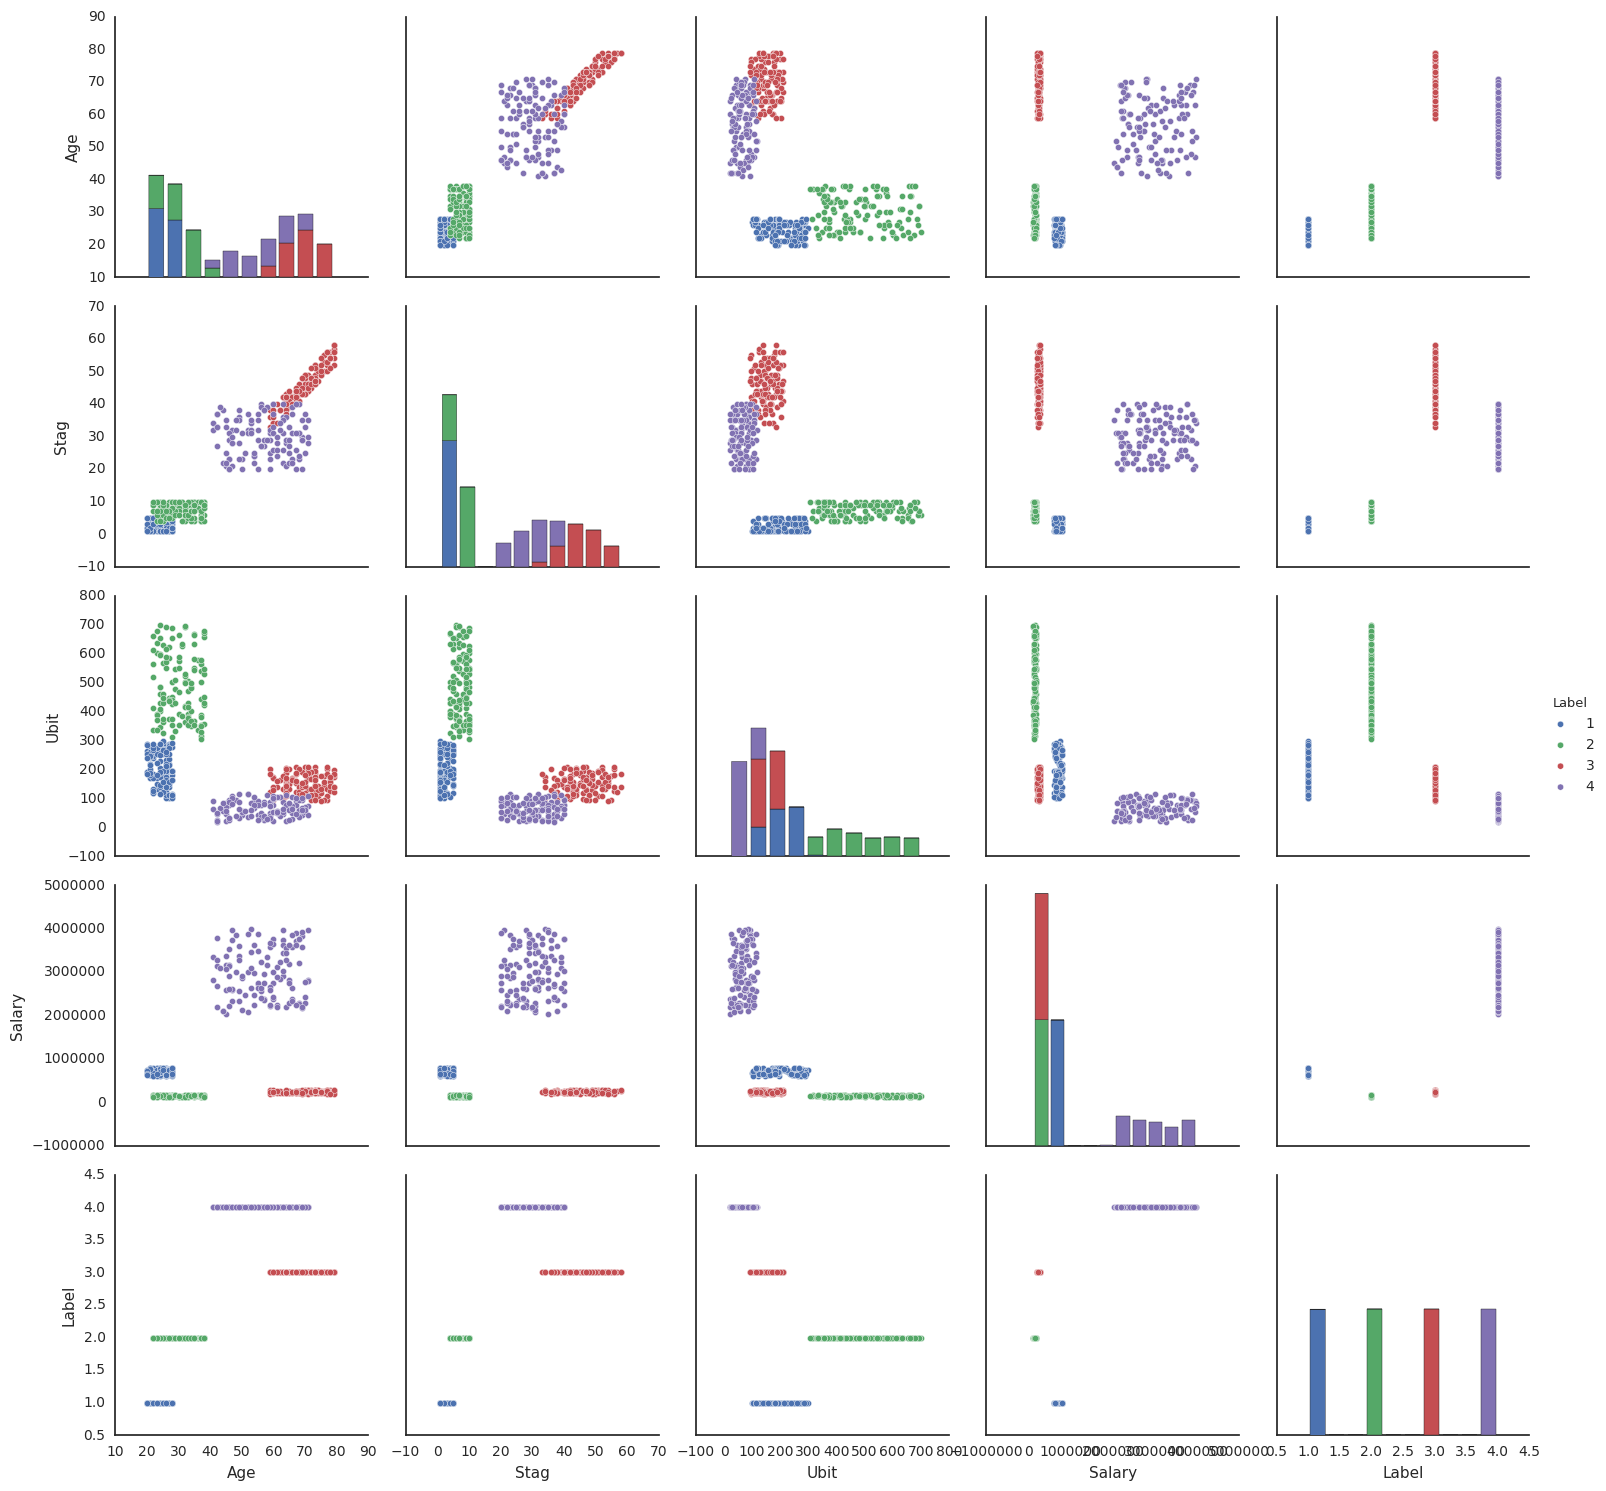

In [42]:
sns.pairplot(final, hue="Label", size=3)

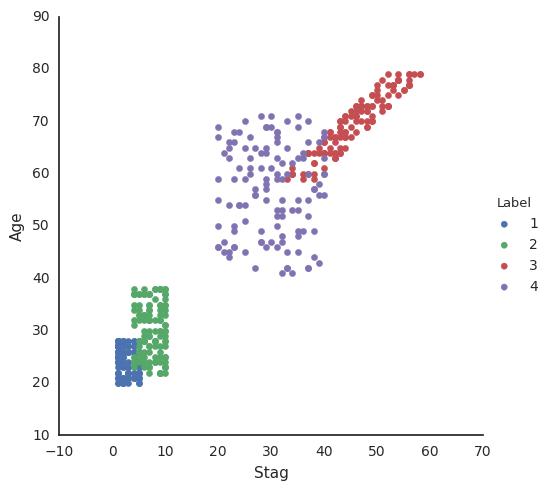

In [30]:
sns.FacetGrid(final, hue="Label", size=5).map(plt.scatter, "Stag", "Age").add_legend()

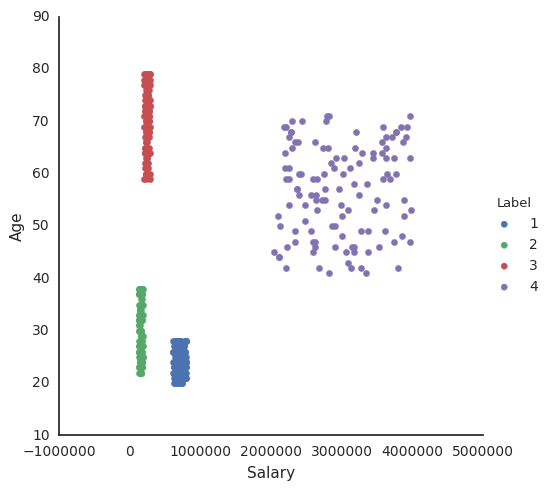

In [31]:
sns.FacetGrid(final, hue="Label", size=5).map(plt.scatter, "Salary", "Age").add_legend()

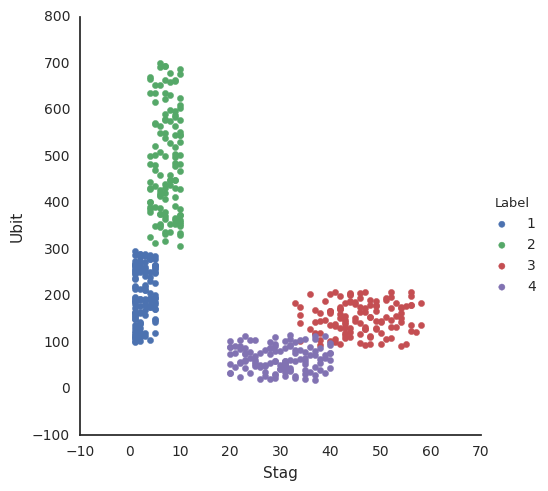

In [33]:
sns.FacetGrid(final, hue="Label", size=5).map(plt.scatter, "Stag", "Ubit").add_legend()

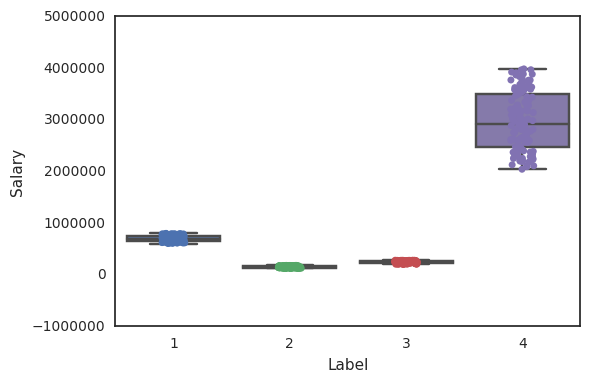

In [38]:
sns.boxplot(x="Label", y="Salary", data=final)
ax = sns.stripplot(x="Label", y="Salary", data=final, jitter=True, edgecolor="gray")

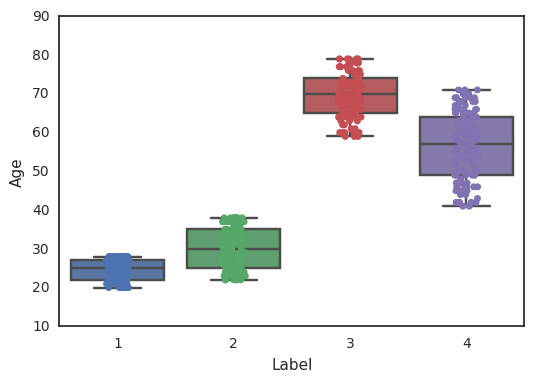

In [37]:
sns.boxplot(x="Label", y="Age", data=final)
ax = sns.stripplot(x="Label", y="Age", data=final, jitter=True, edgecolor="gray")

In [47]:
final[final.Label==1].describe()

,Age,Stag,Ubit,Salary,Label
count,121.000000,121.000000,121.000000,121.000000,121.0
mean,24.504132,2.586777,203.024793,700447.280992,1.0
std,2.536809,1.492590,57.666059,57143.673294,0.0
min,20.000000,1.000000,101.000000,602584.000000,1.0
25%,22.000000,1.000000,158.000000,649111.000000,1.0
50%,25.000000,2.000000,196.000000,692754.000000,1.0
75%,27.000000,4.000000,257.000000,747401.000000,1.0
max,28.000000,5.000000,297.000000,799461.000000,1.0


Первый класс клиентов:
От 20 до 28 лет, стаж от 1 до 5 лет, убыток от 100 до 300%, Зп от 600 000 до 800 000к

Описание:
Молодые люди с большой разраплатой, недавно купили машину, имеют средний убыток

In [48]:
final[final.Label==2].describe()

,Age,Stag,Ubit,Salary,Label
count,121.000000,121.000000,121.000000,121.000000,121.0
mean,30.107438,7.322314,487.140496,149461.619835,2.0
std,5.115013,2.021612,112.865651,17327.340695,0.0
min,22.000000,4.000000,306.000000,120185.000000,2.0
25%,25.000000,6.000000,387.000000,136331.000000,2.0
50%,30.000000,7.000000,471.000000,148751.000000,2.0
75%,35.000000,9.000000,578.000000,163239.000000,2.0
max,38.000000,10.000000,700.000000,179863.000000,2.0


Второй сегмент клиентов:
От 22 до 38 лет, стаж от 4 до 10 лет, убыток от 300 до 700%, Зп от 100 000 до 180 000к

Описание:
Люди постарше, типичный low-mass/mass сегмент, имеют уже достаточно большой стаж, при этом убыток от них высокий, а зарплата у них низкая 

In [49]:
final[final.Label==3].describe()

,Age,Stag,Ubit,Salary,Label
count,121.00000,121.000000,121.000000,121.000000,121.0
mean,69.85124,45.826446,152.380165,242958.446281,3.0
std,5.68721,6.113752,32.875334,24325.309127,0.0
min,59.00000,33.000000,92.000000,200043.000000,3.0
25%,65.00000,42.000000,128.000000,220775.000000,3.0
50%,70.00000,46.000000,153.000000,243203.000000,3.0
75%,74.00000,50.000000,180.000000,267884.000000,3.0
max,79.00000,58.000000,209.000000,279472.000000,3.0


Третий сегмент клиентов:
От 60 до 80 лет, стаж от 33 до 58 лет, убыток от 92 до 209%, Зп от 200 000 до 280 000к

Описание:
Пожилые люди, имеют огромный стаж, средний-низкий убыток и не очень высокую зп

In [50]:
final[final.Label==4].describe()

,Age,Stag,Ubit,Salary,Label
count,121.000000,121.000000,121.000000,1.210000e+02,121.0
mean,56.818182,29.933884,65.752066,2.978736e+06,4.0
std,8.721621,5.832003,25.988549,5.723718e+05,0.0
min,41.000000,20.000000,20.000000,2.040290e+06,4.0
25%,49.000000,25.000000,45.000000,2.475804e+06,4.0
50%,57.000000,30.000000,62.000000,2.911694e+06,4.0
75%,64.000000,35.000000,87.000000,3.494387e+06,4.0
max,71.000000,40.000000,116.000000,3.982828e+06,4.0


Четвертый сегмент клиентов:
От 41 до 71 лет, стаж от 20 до 40 лет, убыток от 20 до 116%, Зп от 2 до 4 млн.

Описание:
Премиум клиенты, машину имеют давно, от них минимальный убыток, огромная зп

In [37]:
final.to_csv('final.csv')

In [40]:
writer = ExcelWriter('final.xlsx')
final.to_excel(writer)
writer.save() 